In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tifffile import imread 
from skimage.measure import regionprops, label 
import os
import csv

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def get_intersection(coords_1, coords_2):
    # function to find coordinates that are present in both matched objects
    intersection = 0
    
    for c1 in range(len(coords_1)):
        for c2 in range(len(coords_2)):
            if coords_1[c1][0] ==coords_2[c2][0] and coords_1[c1][1] ==coords_2[c2][1]:
                intersection = intersection + 1
    return intersection

def get_union(coords_1, coords_2, intersection):
    # function to find coordinates that are present in one, other, or both
    # matched objects (but don't want to count twice!)
    union = len(coords_1) + len(coords_2) - intersection
    return union

def get_jaccard(coords_1, coords_2):
    # jaccard index is intersection divided by union
    intersection = get_intersection(coords_1, coords_2)
    union = get_union(coords_1, coords_2, intersection)
    if union ==0:
        return np.nan
    else:
        return intersection/union

def process_image(image_path):
    # returns the regionprops for an image path
    image = label(imread(image_path))
    props = regionprops(image)
    return props

def return_coords(props): 
    # returns the total coordinates of the mitochondria in each cell
    total_coords = []
    for prop in props:
        if len(total_coords)==0:
            total_coords = prop.coords
        else:
            total_coords = np.concatenate((total_coords, prop.coords))
    return total_coords


0.8710191082802548


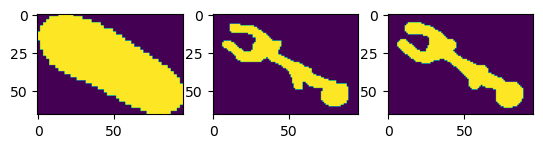

In [6]:
# to go through each image folder in directory
for image_number in range (1, 11):
    if image_number!=10:
        image = "00" + str(image_number)
    else:
        image = "010"
        
    # accessing folders where images are located
    cellpose_folder = "/Volumes/Untitled 1/cell masks from cellpose"
    annotated_folder = os.path.join("/Volumes/Untitled 1/Annotated", image)
    
    annotated_tif_files = [file for file in os.listdir(annotated_folder) if file.endswith(".tif")]
    cellpose_tif_folder = [file for file in os.listdir(cellpose_folder) if file.endswith(".tif") and file.startswith("0")]
    
    parameters = ["50ms_8pc", "50ms_8pcDN","50ms_12pc", "50ms_12pcDN","50ms_20pc", "50ms_20pcDN",
                  "100ms_4pc", "100ms_4pcDN", "100ms_6pc", "100ms_6pcDN", "100ms_10pc", "100ms_10pcDN"]
    
    # get cellpose path    
    cellpose_tif_file = [file for file in cellpose_tif_folder if file.startswith(image)]
    cellpose_path = os.path.join(cellpose_folder, cellpose_tif_file[0]) 
    
    props_cellpose = process_image(cellpose_path)
    
    # get whole image of gt
    whole_gt_image = imread(os.path.join(annotated_folder, "300ms_100pc.tif"))
    nrows, ncols = whole_gt_image.shape
    # initialise to store jaccard indexes
    total = []

    # go through each cell in cellpose
    for cell in range (0, len(props_cellpose)):
        jaccard_indexes = [] # according to parameters array
        
        #(min_row, min_col, max_row, max_col)
        cell_0_bbox = props_cellpose[cell].bbox  
        offset = 16
        
        if ncols>cell_0_bbox[3]+offset:
            # fixes issue when mito box is outside of cell box
            if ncols < cell_0_bbox[3]+offset:
                max_col = ncols-1
            else:
                max_col = cell_0_bbox[3] + offset
            
            cell_0_bbox_corr = (cell_0_bbox[0], cell_0_bbox[1] + offset, cell_0_bbox[2], max_col)
        
    
            # min_row and min_col from the bbox
            cell_0_coords = props_cellpose[cell].coords
            cell_0_coords_crop = cell_0_coords.copy()
            cell_0_coords_crop[:,0] -= cell_0_bbox[0]
            cell_0_coords_crop[:,1] -= cell_0_bbox[1]
        
            # repeating the following code for each image aquisition parameter 
            for parameter in parameters:
                # get whole image of test
                whole_test_image = imread(os.path.join(annotated_folder, parameter+".tif"))
                nrows, ncols = whole_test_image.shape
                
                # get cropped gt and test images according to cell 
                mito_crop_gt = whole_gt_image[cell_0_bbox_corr[0]:cell_0_bbox_corr[2], cell_0_bbox_corr[1]:cell_0_bbox_corr[3]]
                mito_crop_test = whole_test_image[cell_0_bbox_corr[0]:cell_0_bbox_corr[2], cell_0_bbox_corr[1]:cell_0_bbox_corr[3]]
            
                props_gt_mito = regionprops(mito_crop_gt)
                props_test_mito = regionprops(mito_crop_test)
            
                gt_total_coords = return_coords(props_gt_mito)
                test_total_coords = return_coords(props_test_mito)
        
                # get jaccard index
                index = get_jaccard(gt_total_coords, test_total_coords)
                jaccard_indexes.append(index)
            total.append(jaccard_indexes)

    # creating csv files
    filename = 'Jaccard Index Sdh2 ' +str(image)+'.csv'
    filepath = os.path.join("/Volumes/Untitled 1/Annotated", filename)
    file = open(filepath, mode='w', newline='')
    csvwriter = csv.writer(file)
    csvwriter.writerow(["Cell", parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], 
                            parameters[5], parameters[6], parameters[7], parameters[8], parameters[9], parameters[10], parameters[11]])
    
    count = 1
    for j_index in total:
        csvwriter.writerow([count, j_index[0], j_index[1], j_index[2], j_index[3], j_index[4], 
                        j_index[5], j_index[6], j_index[7], j_index[8], j_index[9], 
                            j_index[10], j_index[11]])
        count = count +  1
    file.close()

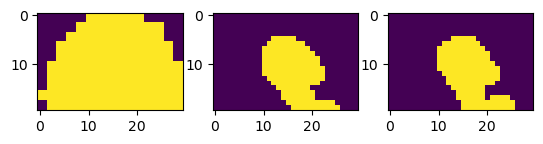

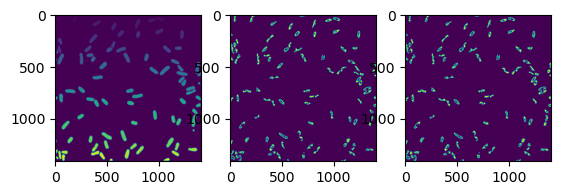

In [7]:
# just plotting
fig, ax = plt.subplots(1, 3)
ax[0].imshow(imread(cellpose_path)[cell_0_bbox[0]:cell_0_bbox[2], cell_0_bbox[1]:cell_0_bbox[3]])
ax[1].imshow(whole_gt_image[cell_0_bbox_corr[0]:cell_0_bbox_corr[2], cell_0_bbox_corr[1]:cell_0_bbox_corr[3]])
ax[2].imshow(whole_test_image[cell_0_bbox_corr[0]:cell_0_bbox_corr[2], cell_0_bbox_corr[1]:cell_0_bbox_corr[3]])

fig, ax = plt.subplots(1, 3)
ax[0].imshow(imread(cellpose_path))
ax[1].imshow(whole_gt_image)
ax[2].imshow(whole_test_image)